In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

from scipy.sparse import diags
import warnings

## Heat flow equation

We create a finite difference solution to the following system using a Crank-Nicholson finite difference scheme:

$u_t=u_{xx},\quad x\in[a,b],\,t\in(0,T]$

$u(x,0)=u_0(x)$

$h_a(t)=c_a(t)u(a,t)+d_a(t)u_x(a,t)$

$h_b(t)=c_b(t)u(b,t)+d_b(t)u_x(b,t)$.

In [8]:
def heat_equation(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b):
    """Performs the Crank Nicolson method for the heat equation."""
    h = (b - a) / (N_x - 1)
    k = T / (N_t - 1)
    
    lamby = k / h / h / 2
    
    x = np.linspace(a, b, N_x)
    t = np.linspace(0, T, N_t + 1)
    
    # evaluate the boundary condition functions along x or t
    H_a = h_a(x)
    H_b = h_b(x)
    C_a = c_a(t)
    C_b = c_b(t)
    D_a = d_a(t)
    D_b = d_b(t)
    f_x0 = u_0(x)
    
    # construct A
    A = np.zeros((N_x - 2, N_x - 2))
    np.fill_diagonal(A, 1 - 2 * lamby)
    np.fill_diagonal(A[1:], lamby)
    np.fill_diagonal(A[:,1:], lamby)
    
    # construct B
    B = np.zeros((N_x, N_x))
    np.fill_diagonal(B, 1 + 2 * lamby)
    np.fill_diagonal(B[1:], -lamby)
    np.fill_diagonal(B[:,1:], -lamby)
    
    # zero out the top and bottom rows of B
    B[0] = np.zeros(N_x)
    B[-1] = np.zeros(N_x)
    
    # temporal iteration
    yous = [f_x0]
    
    for j in range(1, N_t):
        # modify B to leave boundary conditions intact
        B[0, 0] = h * C_a[j] - D_a[j]
        B[0, 1] = D_a[j]
        B[-1, -1] = h * C_b[j] + D_b[j]
        B[-1, -2] = -D_b[j]
        
        # calculate the right hand side
        temp = np.dot(A, yous[-1][1:-1])
        
        # solve for U^{j+1} on the left after concatenating the right hand side
        yous.append(la.solve(B, np.concatenate(([h * H_a[j]], temp, [h * H_b[j]]))))
    
    return np.array(yous)

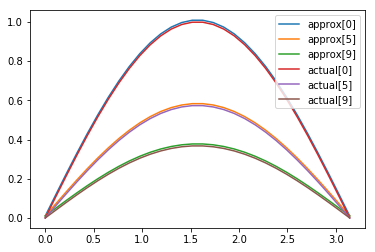

In [7]:
# Test should produce np.exp(-t) * np.sin(x) as a solution
actual = lambda x, t: np.exp(-t) * np.sin(x)

def heat_eq_actual(a, b, T, N_x, N_t, func):
    
    delx = (b-a)/(N_x-1)
    delt = T/(N_t-1)
    
    # this is a specific solution for testing purposes
    U = np.zeros((N_t,N_x))
    
    for j in range(0,N_t):
        t = j*delt
        for k in range(0,N_x):
            x= k*delx
            U[j,k] = func(x,t)

    return U

# boundary condition functions
h_a = lambda t: np.zeros_like(t) if type(t) == np.ndarray else 0
c_a = lambda t: np.ones_like(t) if type(t) == np.ndarray else 1
d_a = lambda t: np.zeros_like(t) if type(t) == np.ndarray else 0

h_b = lambda t: np.zeros_like(t) if type(t) == np.ndarray else 0
c_b = lambda t: np.ones_like(t) if type(t) == np.ndarray else 1
d_b = lambda t: np.zeros_like(t) if type(t) == np.ndarray else 0

u_0 = lambda x: np.sin(x)

# conditions
a = 0
b = np.pi
T = 1.0
N_x = 30
N_t = 10

soln = heat_equation(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b)

x = np.linspace(a, b, N_x)

plt.plot(x, soln[0] + 0.01, label='approx[0]')
plt.plot(x, soln[5] + 0.01, label='approx[5]')
plt.plot(x, soln[9] + 0.01, label='approx[9]')

actual_U = heat_eq_actual(a, b, T, N_x, N_t, actual)

plt.plot(x, actual_U[0], label='actual[0]')
plt.plot(x, actual_U[5], label='actual[5]')
plt.plot(x, actual_U[9], label='actual[9]')

plt.legend()

plt.show()